## Exercise 3: Going Deeper

As usual, pick **AT LEAST ONE** of the following exercises to complete.

In [9]:
# Standard imports.
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random

# Plus one non standard one -- we need this to sample from policies.
from torch.distributions import Categorical

import math
from collections import namedtuple, deque
from itertools import count

from tqdm import tqdm
from datetime import datetime

import wandb

---
# Exercise 3.1: Solving Lunar Lander with `REINFORCE` (easy)

Use my (or even better, improve on my) implementation of `REINFORCE` to solve the [Lunar Lander Environment](https://gymnasium.farama.org/environments/box2d/lunar_lander/). This environment is a little bit harder than Cartpole, but not much. Make sure you perform the same types of analyses we did during the lab session to quantify and qualify the performance of your agents.

In [16]:
# TRAIN AGENT
def train_agent(agent, agent_name, env, env_name, episodes, max_length=500, stats_every=10, env_render=None, device="cuda"):
    # Initialize wandb
    wandb_init(agent, agent_name, env_name, episodes, device=device)

    # Track episode rewards in a list
    stats_reward_list = []
    tot_reward = 0

    # Loop over the episodes
    for episode in tqdm(range(episodes), desc="Episodes", unit="episode", leave=True):
        # Initialize lists to store the states, actions, and rewards
        state_list = []
        action_list = []
        reward_list = []

        # Generate the episode
        stats_actor_loss, stats_v_loss = 0, 0
        (state, info) = env.reset()

        # Run the episode  
        for length in range(max_length):
            # Select an action
            action = agent.act(state)

            # Do the action in the environment
            next_state, reward, term, trunc, _ = env.step(action)

            tot_reward += reward

            # Store the state, action, and reward
            state_list.append(state)
            action_list.append(action)
            reward_list.append(reward)

            # If the episode is done, break
            if term or trunc or length == max_length-1: # or the total reward is too low (optional)
                a_loss, v_loss = agent.train(state_list, action_list, reward_list)
                stats_reward_list.append((episode, tot_reward, length))

                stats_actor_loss += a_loss
                stats_v_loss += v_loss

                # Wandb logging training stats
                wandb.log({"train/total_reward": tot_reward, "train/episode_length": length, "train/actor_loss": a_loss, "train/value_loss": v_loss}, step=episode)

                tot_reward = 0
                if not episode % stats_every:
                    # Evaluate the agent
                    total_reward = np.mean(stats_reward_list[-stats_every:], axis=0)[1]
                    total_length = np.mean(stats_reward_list[-stats_every:], axis=0)[2]
                    actor_loss = stats_actor_loss/stats_every
                    value_loss = stats_v_loss/stats_every
                    
                    print(f"Episode {episode}, Time steps: {length}, Total reward: {total_reward:.1f}, Episode length: {total_length:.1f}, Actor Loss: {actor_loss:.3f}, Value Loss: {value_loss:.3f}")
                    wandb.log({"eval/time_steps": length, "eval/total_reward": total_reward, "eval/episode_length": total_length, "eval/actor_loss": actor_loss, "eval/value_loss": value_loss}, step=episode)

                    # Visualize the agent
                    if env_render is not None:
                        display_agent(agent, env_render)
                break
                
            state = next_state
    
    # Close the environment
    env.close()
    if env_render is not None:
        env_render.close()
    # Finish wandb
    wandb.finish()
    
    # Plot 
    plot_stats(stats_reward_list)

    return stats_reward_list


def display_agent(agent, env_render, max_length=500):
    (state, _) = env_render.reset()
    for _ in range(max_length):
        action = agent.act(state)
        (state, _, _, _, _) = env_render.step(action)


def plot_stats(stats_rewards_list):
    # plot stats
    def get_running_stat(stat, stat_len):
        cum_sum = np.cumsum(np.insert(stat, 0, 0)) 
        return (cum_sum[stat_len:] - cum_sum[:-stat_len]) / stat_len

    episode, r, l = np.array(stats_rewards_list).T
    cum_r = get_running_stat(r, 10)
    cum_l = get_running_stat(l, 10)

    # Plots
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].set_title("Episode reward")
    ax[0].plot(episode[-len(cum_r):], cum_r)
    ax[0].plot(episode, r, alpha=0.3)
    ax[0].set_xlabel("Episode")
    ax[0].set_ylabel("Episode reward")

    ax[1].set_title("Episode length")
    ax[1].plot(episode[-len(cum_l):], cum_l)
    ax[1].plot(episode, l, alpha=0.3)
    ax[1].set_xlabel("Episode")
    ax[1].set_ylabel("Episode length")
    

# Function to initialize wandb
def wandb_init(agent, algorithm, env, episodes, device="cuda", project="DLA Assigment 3"):
    # Initialize wandb
    wandb.init(
        project=project,
        name=algorithm,
        # Track hyperparameters and run metadata
        config={
            "algorithm": algorithm,
            "environment": env,
            "episodes": episodes,
            "learning_rate": agent.lr,
            "gamma": agent.gamma,
            "optimizer": "Adam",
            "device": device.type
        }
    )

In [11]:
# Policy network
class PolicyNet(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, s):
        return self.net(s)
    
# Value network
class ValueNet(nn.Module):
    def __init__(self, state_size, hidden_size=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
    def forward(self, s):
        return self.net(s)

In [12]:
# REINFORCE AGENT
class REINFORCEAgent():
    def __init__(self, state_size, action_size, hidden_size, lr, gamma, baseline=True, device='cuda'):
        self.action_size = action_size
        self.actor = PolicyNet(state_size, action_size, hidden_size).to(device)
        self.act_optimizer = optim.Adam(self.actor.parameters(), lr=lr)
        self.baseline = baseline
        self.value = ValueNet(state_size, hidden_size).to(device)
        self.value_optimizer = optim.Adam(self.value.parameters(), lr=lr)
        self.lr = lr
        self.gamma = gamma

    def act(self, state, device='cuda'):
        with torch.no_grad():
            state = torch.FloatTensor(state).to(device)
            probs = self.actor(state)
            probs  = probs.detach().cpu().numpy()
            action = np.random.choice(np.arange(self.action_size), p=probs)
        return action

    def train(self, state_list, action_list, reward_list, device='cuda'):
        # Transform the reward to a return
        len_rew = len(reward_list)
        return_array = np.zeros((len_rew))

        # Compute the return: G_t = r_t + gamma * r_{t+1} + gamma^2 * r_{t+2} + ...
        g_return = 0.
        for i in reversed(range(len_rew)):
            g_return = reward_list[i] + self.gamma * g_return
            return_array[i] = g_return

        # Transform the lists to tensors
        states = torch.FloatTensor(state_list).to(device)
        actions = torch.LongTensor(action_list).to(device).view(-1, 1)
        returns = torch.FloatTensor(return_array).to(device).view(-1, 1)

        # Get value function estimates
        if self.baseline: 
            values = self.value(states).to(device)
            with torch.no_grad():
                advantages = returns - values
        else:
            advantages = returns

        # Compute the loss
        selected_action_prob = self.actor(states).gather(1, actions)

        # REINFORCE with BASELINE loss
        actor_loss = -torch.mean(torch.log(selected_action_prob) * advantages)

        # Optimize the actor
        self.act_optimizer.zero_grad()
        actor_loss.backward()
        self.act_optimizer.step()

        # Compute the value loss
        if self.baseline:
            value_loss = F.mse_loss(values, returns)
            self.value_optimizer.zero_grad()
            value_loss.backward()
            self.value_optimizer.step()

        return actor_loss.detach().cpu().numpy(), value_loss.detach().cpu().numpy() if self.baseline else 0

## Without Baseline

### Cartpole

Episodes:   0%|          | 0/2000 [00:00<?, ?episode/s]

Episode 0, Time steps: 23, Total reward: 24.0, Episode length: 23.0, Actor Loss: 0.040, Value Loss: 0.000


Episodes:  10%|▉         | 199/2000 [00:04<00:58, 30.57episode/s]

Episode 200, Time steps: 61, Total reward: 33.5, Episode length: 32.5, Actor Loss: 0.077, Value Loss: 0.000


Episodes:  20%|██        | 400/2000 [00:09<00:26, 59.39episode/s]

Episode 400, Time steps: 36, Total reward: 38.1, Episode length: 37.1, Actor Loss: 0.035, Value Loss: 0.000


Episodes:  30%|███       | 600/2000 [00:42<05:21,  4.35episode/s]

Episode 600, Time steps: 420, Total reward: 293.8, Episode length: 292.8, Actor Loss: 0.195, Value Loss: 0.000


Episodes:  40%|████      | 800/2000 [01:38<05:42,  3.50episode/s]

Episode 800, Time steps: 499, Total reward: 490.0, Episode length: 489.0, Actor Loss: 0.209, Value Loss: 0.000


Episodes:  50%|█████     | 1000/2000 [02:20<04:37,  3.61episode/s]

Episode 1000, Time steps: 499, Total reward: 363.1, Episode length: 362.1, Actor Loss: 0.190, Value Loss: 0.000


Episodes:  60%|██████    | 1200/2000 [02:47<01:27,  9.18episode/s]

Episode 1200, Time steps: 114, Total reward: 207.5, Episode length: 206.5, Actor Loss: 0.075, Value Loss: 0.000


Episodes:  70%|███████   | 1400/2000 [03:04<00:50, 11.94episode/s]

Episode 1400, Time steps: 128, Total reward: 112.2, Episode length: 111.2, Actor Loss: 0.059, Value Loss: 0.000


Episodes:  80%|███████▉  | 1599/2000 [03:19<00:24, 16.33episode/s]

Episode 1600, Time steps: 95, Total reward: 117.8, Episode length: 116.8, Actor Loss: 0.066, Value Loss: 0.000


Episodes:  90%|█████████ | 1800/2000 [03:58<01:08,  2.93episode/s]

Episode 1800, Time steps: 457, Total reward: 328.9, Episode length: 327.9, Actor Loss: 0.151, Value Loss: 0.000


Episodes: 100%|██████████| 2000/2000 [04:19<00:00,  7.71episode/s]


eval/actor_loss,▁▃▁▇█▇▃▂▂▆
eval/episode_length,▁▁▁▅█▆▄▂▂▆
eval/time_steps,▁▂▁▇██▂▃▂▇
eval/total_reward,▁▁▁▅█▆▄▂▂▆
eval/value_loss,▁▁▁▁▁▁▁▁▁▁
train/actor_loss,▂▂▃▅▃▂▂▁▂▃▇██▇▇▇█▁█▇▇▃▃▃▃▃▃▃▃▃▃▂▃▃▅▆▃▃▂▅
train/episode_length,▁▁▁▂▂▁▁▁▁▂███████▁███▃▂▃▃▃▂▃▃▃▃▂▂▃██▃▃▁▅
train/total_reward,▁▁▁▂▂▁▁▁▁▂███████▁███▃▂▃▃▃▂▃▃▃▃▂▂▃██▃▃▁▅
train/value_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/actor_loss,0.15094
eval/episode_length,327.89


[(0, 24.0, 23),
 (1, 15.0, 14),
 (2, 12.0, 11),
 (3, 27.0, 26),
 (4, 9.0, 8),
 (5, 11.0, 10),
 (6, 32.0, 31),
 (7, 21.0, 20),
 (8, 11.0, 10),
 (9, 22.0, 21),
 (10, 20.0, 19),
 (11, 10.0, 9),
 (12, 32.0, 31),
 (13, 27.0, 26),
 (14, 21.0, 20),
 (15, 35.0, 34),
 (16, 31.0, 30),
 (17, 10.0, 9),
 (18, 10.0, 9),
 (19, 18.0, 17),
 (20, 16.0, 15),
 (21, 16.0, 15),
 (22, 8.0, 7),
 (23, 49.0, 48),
 (24, 12.0, 11),
 (25, 22.0, 21),
 (26, 20.0, 19),
 (27, 14.0, 13),
 (28, 24.0, 23),
 (29, 22.0, 21),
 (30, 16.0, 15),
 (31, 13.0, 12),
 (32, 32.0, 31),
 (33, 26.0, 25),
 (34, 29.0, 28),
 (35, 35.0, 34),
 (36, 27.0, 26),
 (37, 28.0, 27),
 (38, 16.0, 15),
 (39, 37.0, 36),
 (40, 17.0, 16),
 (41, 11.0, 10),
 (42, 12.0, 11),
 (43, 54.0, 53),
 (44, 26.0, 25),
 (45, 45.0, 44),
 (46, 29.0, 28),
 (47, 9.0, 8),
 (48, 19.0, 18),
 (49, 44.0, 43),
 (50, 23.0, 22),
 (51, 40.0, 39),
 (52, 14.0, 13),
 (53, 19.0, 18),
 (54, 65.0, 64),
 (55, 27.0, 26),
 (56, 41.0, 40),
 (57, 73.0, 72),
 (58, 33.0, 32),
 (59, 24.0, 23),

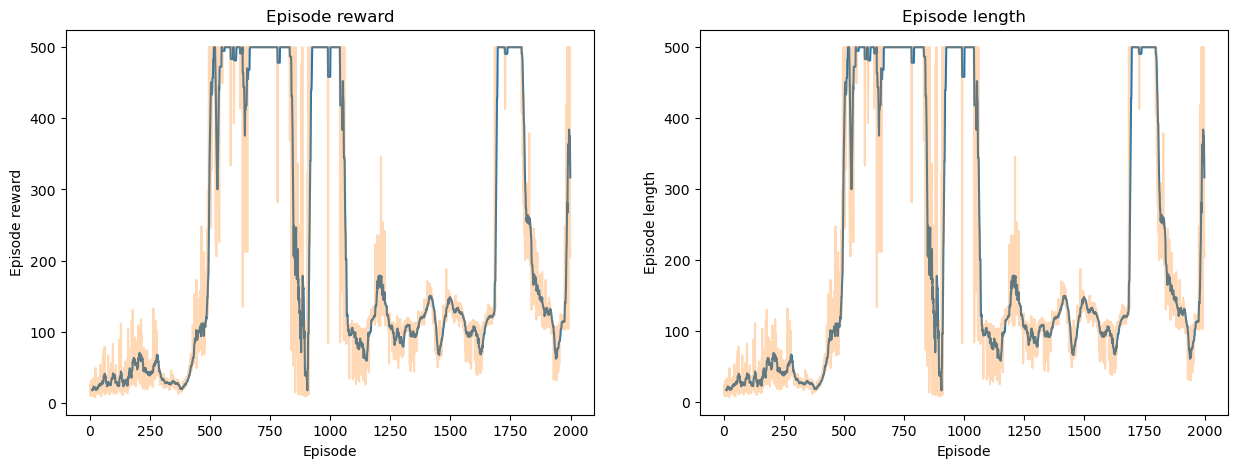

In [13]:
# Initialize the environment.
env_name = "CartPole-v1"
env = gym.make(env_name)
# env_render = gym.make(env_name, render_mode="human")
env_render = None
action_size = env.action_space.n
state_size = env.observation_space.shape[0]
# print("Action size:", action_size, "State size:", state_size)

# Hyperparameters
lr = 1e-2
gamma = 0.99
hidden_size = 16
episodes = 2000
max_length = 500
stats_every = 200 

# Initialize the policy agent
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
date = datetime.now().strftime("%Y%m%d-%H%M%S")
baseline = False
agent_name = "REINFORCE" + ("_BASELINE" if baseline else "")
agent_name = agent_name + "_" + date
agent = REINFORCEAgent(state_size, action_size, hidden_size, lr, gamma, baseline=baseline, device=device)

# Train the agent
train_agent(agent, agent_name, env, env_name, episodes, max_length, stats_every, env_render, device)

<frozen importlib._bootstrap>:241: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


Episodes:   0%|          | 0/5000 [00:00<?, ?episode/s]

Episode 0, Time steps: 83, Total reward: -53.4, Episode length: 83.0, Actor Loss: -0.083, Value Loss: 0.000


Episodes:  10%|█         | 500/5000 [00:55<16:22,  4.58episode/s]

Episode 500, Time steps: 499, Total reward: -100.2, Episode length: 155.5, Actor Loss: -0.003, Value Loss: 0.000


Episodes:  20%|██        | 1000/5000 [03:09<13:38,  4.89episode/s]

Episode 1000, Time steps: 499, Total reward: 46.0, Episode length: 420.1, Actor Loss: 0.019, Value Loss: 0.000


Episodes:  30%|███       | 1500/5000 [05:41<20:28,  2.85episode/s]

Episode 1500, Time steps: 499, Total reward: 74.6, Episode length: 458.9, Actor Loss: 0.011, Value Loss: 0.000


Episodes:  40%|████      | 2000/5000 [08:20<16:06,  3.10episode/s]

Episode 2000, Time steps: 499, Total reward: 106.6, Episode length: 474.3, Actor Loss: 0.034, Value Loss: 0.000


Episodes:  50%|█████     | 2500/5000 [10:26<11:12,  3.72episode/s]

Episode 2500, Time steps: 499, Total reward: 80.8, Episode length: 391.1, Actor Loss: 0.020, Value Loss: 0.000


Episodes:  60%|██████    | 3000/5000 [12:33<09:33,  3.49episode/s]

Episode 3000, Time steps: 499, Total reward: 63.8, Episode length: 397.9, Actor Loss: 0.007, Value Loss: 0.000


Episodes:  70%|██████▉   | 3499/5000 [14:49<01:28, 17.02episode/s]

Episode 3500, Time steps: 92, Total reward: 85.3, Episode length: 424.3, Actor Loss: -0.003, Value Loss: 0.000


Episodes:  80%|████████  | 4000/5000 [16:39<05:18,  3.14episode/s]

Episode 4000, Time steps: 499, Total reward: 105.1, Episode length: 356.6, Actor Loss: 0.002, Value Loss: 0.000


Episodes:  90%|█████████ | 4500/5000 [18:53<02:36,  3.19episode/s]

Episode 4500, Time steps: 499, Total reward: 57.8, Episode length: 429.2, Actor Loss: 0.009, Value Loss: 0.000


Episodes: 100%|██████████| 5000/5000 [21:00<00:00,  3.97episode/s]


eval/actor_loss,▁▆▇▇█▇▆▆▆▆
eval/episode_length,▁▂▇██▇▇▇▆▇
eval/time_steps,▁██████▁██
eval/total_reward,▃▁▆▇█▇▇▇█▆
eval/value_loss,▁▁▁▁▁▁▁▁▁▁
train/actor_loss,▄▁▃▅▆▆▇▇▅▇▇▇▇▇▇▇▇▇█▃▇█▆▇▇▇▇██▇▇▇▇▇▇▇▇▇▇▇
train/episode_length,▁▁▂▃█▅▃█▅███▃███▂█▅▄█▆▄████▅▄█▅█████▁███
train/total_reward,▄▂▄▄▄▅▆▅▃▆▆▇▅▆▆▆▅▇█▁▆█▄▆▆▆▇██▆█▆▇▆▆▅▆▆▇▆
train/value_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/actor_loss,0.00864
eval/episode_length,429.152


[(0, -53.378419670813756, 83),
 (1, -254.53384665731772, 74),
 (2, -108.07358939350661, 109),
 (3, -120.04348459770569, 108),
 (4, -110.70231121168526, 94),
 (5, -128.18371950845685, 104),
 (6, -476.873574912925, 129),
 (7, -178.91685768880092, 74),
 (8, -368.39114987137185, 96),
 (9, -281.5696230051517, 92),
 (10, -420.72880140180314, 93),
 (11, -384.00270772821045, 107),
 (12, -204.39485965574931, 67),
 (13, -165.24983912699585, 64),
 (14, -58.09102952831651, 66),
 (15, -249.8079616055467, 62),
 (16, -149.14100140151032, 83),
 (17, -493.72601812230033, 81),
 (18, -121.92879741029901, 95),
 (19, -329.492956539794, 121),
 (20, -501.8578088660685, 114),
 (21, -615.8426935229687, 104),
 (22, -453.9948531334267, 107),
 (23, -170.54741023728968, 89),
 (24, -155.28836113569952, 108),
 (25, -142.38480155185363, 83),
 (26, -280.8124793399876, 69),
 (27, -588.3046215499617, 124),
 (28, 43.01498718692659, 111),
 (29, -104.45007249218857, 70),
 (30, -85.96737075159344, 61),
 (31, -282.2182936421

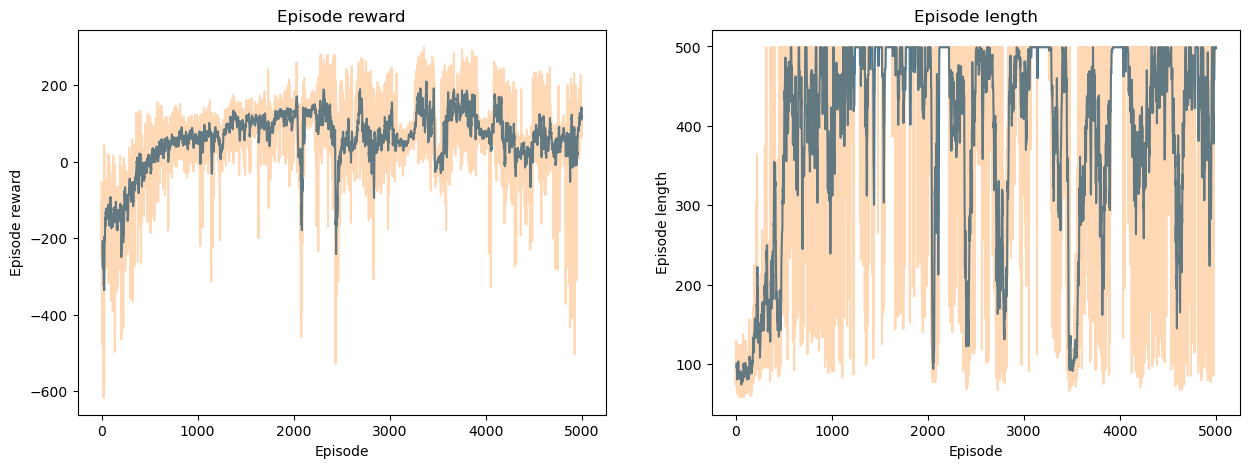

In [14]:
# Initialize the environment.
env_name = "LunarLander-v2"
env = gym.make(env_name)
# env_render = gym.make(env_name, render_mode="human")
env_render = None
action_size = env.action_space.n
state_size = env.observation_space.shape[0]
# print("Action size:", action_size, "State size:", state_size)

# Hyperparameters
lr = 1e-2
gamma = 0.99
hidden_size = 16
episodes = 5000
max_length = 500
stats_every = 500 

# Initialize the policy agent
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dt = datetime.now().strftime("%Y%m%d-%H%M%S")
agent_name = "REINFORCE"
agent_name = agent_name + "_" + dt
agent = REINFORCEAgent(state_size, action_size, hidden_size, lr, gamma, baseline=False, device=device)

# Train the agent
train_agent(agent, agent_name, env, env_name, episodes, max_length, stats_every, env_render, device)

## With Deep Neural Network Baseline

### Cartpole Environment

In [ ]:
# Initialize the environment.
env_name = "CartPole-v1"
env = gym.make(env_name)
# env_render = gym.make(env_name, render_mode="human")
env_render = None
action_size = env.action_space.n
state_size = env.observation_space.shape[0]
print("Action size:", action_size, "State size:", state_size)

# Hyperparameters
lr = 1e-2
gamma = 0.99
hidden_size = 16
episodes = 5000
max_length = 500
stats_every = 500 

# Initialize the policy agent
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
date = datetime.now().strftime("%Y%m%d-%H%M%S")
baseline = True
agent_name = "REINFORCE" + ("_BASELINE" if baseline else "")
agent_name = agent_name + "_" + date
agent = REINFORCEAgent(state_size, action_size, hidden_size, lr, gamma, baseline=baseline, device=device)

# Train the agent
train_agent(agent, agent_name, env, env_name, episodes, max_length, stats_every, env_render, device)

### Lunar Lander Environment

Action size: 4 State size: 8


Episodes:   0%|          | 0/5000 [00:00<?, ?episode/s]

Episode 0, Time steps: 97, Total reward: -249.8, Episode length: 97.0, Actor Loss: -1.855, Value Loss: 183.640


Episodes:   2%|▏         | 100/5000 [00:06<05:31, 14.80episode/s]

Episode 100, Time steps: 72, Total reward: -176.5, Episode length: 95.4, Actor Loss: -0.374, Value Loss: 9.301


Episodes:   4%|▍         | 200/5000 [00:13<05:23, 14.85episode/s]

Episode 200, Time steps: 119, Total reward: -122.2, Episode length: 94.0, Actor Loss: -0.498, Value Loss: 15.496


Episodes:   6%|▌         | 300/5000 [00:22<05:24, 14.46episode/s]

Episode 300, Time steps: 139, Total reward: -141.7, Episode length: 101.3, Actor Loss: 0.248, Value Loss: 5.242


Episodes:   8%|▊         | 400/5000 [00:31<07:06, 10.77episode/s]

Episode 400, Time steps: 172, Total reward: -87.5, Episode length: 111.1, Actor Loss: -0.150, Value Loss: 8.612


Episodes:  10%|█         | 500/5000 [00:40<10:12,  7.35episode/s]

Episode 500, Time steps: 209, Total reward: -55.0, Episode length: 128.1, Actor Loss: 0.131, Value Loss: 2.423


Episodes:  12%|█▏        | 600/5000 [01:04<17:36,  4.17episode/s]

Episode 600, Time steps: 499, Total reward: -14.2, Episode length: 338.0, Actor Loss: 0.359, Value Loss: 19.620


Episodes:  14%|█▍        | 700/5000 [01:32<15:22,  4.66episode/s]

Episode 700, Time steps: 499, Total reward: 22.6, Episode length: 403.3, Actor Loss: 0.162, Value Loss: 11.052


Episodes:  16%|█▌        | 800/5000 [02:04<23:53,  2.93episode/s]

Episode 800, Time steps: 306, Total reward: 45.6, Episode length: 468.6, Actor Loss: -0.592, Value Loss: 92.457


Episodes:  18%|█▊        | 900/5000 [02:36<22:02,  3.10episode/s]

Episode 900, Time steps: 499, Total reward: 49.8, Episode length: 474.1, Actor Loss: 0.179, Value Loss: 17.874


Episodes:  20%|██        | 1000/5000 [03:05<16:36,  4.01episode/s]

Episode 1000, Time steps: 499, Total reward: 61.3, Episode length: 441.2, Actor Loss: -0.037, Value Loss: 9.389


Episodes:  22%|██▏       | 1100/5000 [03:35<20:21,  3.19episode/s]

Episode 1100, Time steps: 499, Total reward: 46.9, Episode length: 484.5, Actor Loss: 0.142, Value Loss: 9.146


Episodes:  24%|██▍       | 1200/5000 [04:08<23:30,  2.69episode/s]

Episode 1200, Time steps: 499, Total reward: 77.2, Episode length: 499.0, Actor Loss: 0.066, Value Loss: 6.795


Episodes:  26%|██▌       | 1300/5000 [04:39<20:59,  2.94episode/s]

Episode 1300, Time steps: 499, Total reward: 68.0, Episode length: 479.3, Actor Loss: 0.085, Value Loss: 10.510


Episodes:  28%|██▊       | 1400/5000 [05:08<17:46,  3.37episode/s]

Episode 1400, Time steps: 499, Total reward: 58.6, Episode length: 433.8, Actor Loss: 0.089, Value Loss: 11.476


Episodes:  30%|███       | 1500/5000 [05:39<18:54,  3.09episode/s]

Episode 1500, Time steps: 499, Total reward: 79.2, Episode length: 491.4, Actor Loss: 0.022, Value Loss: 3.282


Episodes:  32%|███▏      | 1600/5000 [06:10<19:10,  2.96episode/s]

Episode 1600, Time steps: 499, Total reward: 76.5, Episode length: 489.1, Actor Loss: -0.094, Value Loss: 6.084


Episodes:  34%|███▍      | 1700/5000 [06:44<19:13,  2.86episode/s]

Episode 1700, Time steps: 499, Total reward: 86.1, Episode length: 499.0, Actor Loss: -0.018, Value Loss: 3.395


Episodes:  36%|███▌      | 1800/5000 [07:16<18:32,  2.88episode/s]

Episode 1800, Time steps: 103, Total reward: 102.5, Episode length: 491.9, Actor Loss: -0.509, Value Loss: 40.953


Episodes:  38%|███▊      | 1900/5000 [07:50<13:46,  3.75episode/s]

Episode 1900, Time steps: 147, Total reward: 111.3, Episode length: 465.9, Actor Loss: -0.441, Value Loss: 47.104


Episodes:  40%|████      | 2000/5000 [08:21<16:19,  3.06episode/s]

Episode 2000, Time steps: 499, Total reward: 116.7, Episode length: 464.6, Actor Loss: 0.050, Value Loss: 1.383


Episodes:  42%|████▏     | 2100/5000 [08:55<17:49,  2.71episode/s]

Episode 2100, Time steps: 499, Total reward: 142.8, Episode length: 483.5, Actor Loss: 0.037, Value Loss: 0.816


Episodes:  44%|████▍     | 2200/5000 [09:29<14:49,  3.15episode/s]

Episode 2200, Time steps: 499, Total reward: 148.4, Episode length: 489.0, Actor Loss: 0.020, Value Loss: 0.716


Episodes:  46%|████▌     | 2300/5000 [10:00<14:33,  3.09episode/s]

Episode 2300, Time steps: 499, Total reward: 150.4, Episode length: 486.2, Actor Loss: -0.037, Value Loss: 1.073


Episodes:  48%|████▊     | 2400/5000 [10:30<15:26,  2.81episode/s]

Episode 2400, Time steps: 499, Total reward: 128.5, Episode length: 456.9, Actor Loss: 0.066, Value Loss: 3.571


Episodes:  50%|█████     | 2500/5000 [11:00<12:02,  3.46episode/s]

Episode 2500, Time steps: 412, Total reward: 110.4, Episode length: 422.4, Actor Loss: 0.223, Value Loss: 21.839


Episodes:  52%|█████▏    | 2600/5000 [11:31<13:33,  2.95episode/s]

Episode 2600, Time steps: 499, Total reward: 130.1, Episode length: 432.3, Actor Loss: -0.043, Value Loss: 0.839


Episodes:  54%|█████▍    | 2700/5000 [12:01<12:15,  3.13episode/s]

Episode 2700, Time steps: 388, Total reward: 131.5, Episode length: 464.4, Actor Loss: 0.095, Value Loss: 12.846


Episodes:  56%|█████▌    | 2800/5000 [12:35<12:18,  2.98episode/s]

Episode 2800, Time steps: 499, Total reward: 153.9, Episode length: 483.6, Actor Loss: 0.039, Value Loss: 2.014


Episodes:  58%|█████▊    | 2900/5000 [13:06<10:16,  3.41episode/s]

Episode 2900, Time steps: 499, Total reward: 158.8, Episode length: 465.9, Actor Loss: 0.023, Value Loss: 1.565


Episodes:  60%|██████    | 3000/5000 [13:36<07:07,  4.68episode/s]

Episode 3000, Time steps: 499, Total reward: 149.3, Episode length: 439.8, Actor Loss: -0.015, Value Loss: 0.978


Episodes:  62%|██████▏   | 3100/5000 [14:07<11:14,  2.82episode/s]

Episode 3100, Time steps: 317, Total reward: 146.1, Episode length: 444.9, Actor Loss: -0.271, Value Loss: 19.287


Episodes:  64%|██████▍   | 3200/5000 [14:39<08:57,  3.35episode/s]

Episode 3200, Time steps: 434, Total reward: 131.5, Episode length: 445.9, Actor Loss: 0.106, Value Loss: 12.729


Episodes:  66%|██████▌   | 3300/5000 [15:11<10:30,  2.70episode/s]

Episode 3300, Time steps: 499, Total reward: 119.5, Episode length: 448.6, Actor Loss: 0.004, Value Loss: 0.362


Episodes:  68%|██████▊   | 3400/5000 [15:46<09:12,  2.90episode/s]

Episode 3400, Time steps: 499, Total reward: 152.9, Episode length: 495.8, Actor Loss: 0.048, Value Loss: 1.718


Episodes:  70%|███████   | 3500/5000 [16:17<08:28,  2.95episode/s]

Episode 3500, Time steps: 499, Total reward: 166.0, Episode length: 487.4, Actor Loss: 0.008, Value Loss: 0.596


Episodes:  72%|███████▏  | 3600/5000 [16:51<08:30,  2.74episode/s]

Episode 3600, Time steps: 499, Total reward: 167.6, Episode length: 494.2, Actor Loss: 0.001, Value Loss: 0.381


Episodes:  74%|███████▍  | 3700/5000 [17:27<08:26,  2.57episode/s]

Episode 3700, Time steps: 499, Total reward: 162.9, Episode length: 494.2, Actor Loss: 0.002, Value Loss: 0.517


Episodes:  76%|███████▌  | 3800/5000 [18:01<07:15,  2.76episode/s]

Episode 3800, Time steps: 499, Total reward: 167.1, Episode length: 463.3, Actor Loss: 0.034, Value Loss: 1.825


Episodes:  78%|███████▊  | 3900/5000 [18:33<05:34,  3.29episode/s]

Episode 3900, Time steps: 499, Total reward: 150.5, Episode length: 483.8, Actor Loss: 0.008, Value Loss: 0.743


Episodes:  80%|████████  | 4000/5000 [19:05<05:54,  2.82episode/s]

Episode 4000, Time steps: 499, Total reward: 125.7, Episode length: 459.8, Actor Loss: -0.233, Value Loss: 7.468


Episodes:  82%|████████▏ | 4100/5000 [19:37<04:36,  3.25episode/s]

Episode 4100, Time steps: 216, Total reward: 69.3, Episode length: 496.2, Actor Loss: -0.181, Value Loss: 16.423


Episodes:  84%|████████▍ | 4200/5000 [20:08<04:10,  3.19episode/s]

Episode 4200, Time steps: 499, Total reward: 132.0, Episode length: 475.8, Actor Loss: 0.052, Value Loss: 1.712


Episodes:  86%|████████▌ | 4300/5000 [20:39<02:40,  4.36episode/s]

Episode 4300, Time steps: 499, Total reward: 153.7, Episode length: 479.9, Actor Loss: -0.008, Value Loss: 0.422


Episodes:  88%|████████▊ | 4400/5000 [21:06<03:11,  3.13episode/s]

Episode 4400, Time steps: 233, Total reward: 143.4, Episode length: 397.5, Actor Loss: 0.172, Value Loss: 26.168


Episodes:  90%|████████▉ | 4499/5000 [21:18<00:42, 11.86episode/s]

Episode 4500, Time steps: 88, Total reward: 49.0, Episode length: 177.1, Actor Loss: 0.088, Value Loss: 18.949


Episodes:  92%|█████████▏| 4600/5000 [21:31<00:34, 11.66episode/s]

Episode 4600, Time steps: 499, Total reward: 44.6, Episode length: 200.9, Actor Loss: 0.106, Value Loss: 9.094


Episodes:  94%|█████████▍| 4700/5000 [22:05<01:46,  2.81episode/s]

Episode 4700, Time steps: 499, Total reward: 90.6, Episode length: 458.6, Actor Loss: 0.044, Value Loss: 3.560


Episodes:  96%|█████████▌| 4800/5000 [22:37<01:09,  2.87episode/s]

Episode 4800, Time steps: 499, Total reward: 91.4, Episode length: 463.5, Actor Loss: 0.024, Value Loss: 2.453


Episodes:  98%|█████████▊| 4900/5000 [23:05<00:31,  3.20episode/s]

Episode 4900, Time steps: 67, Total reward: 77.9, Episode length: 390.3, Actor Loss: -0.106, Value Loss: 17.642


Episodes: 100%|██████████| 5000/5000 [23:32<00:00,  3.54episode/s]


eval/actor_loss,▁▆▅█▇█▇▅▇▇▇▇▇▇▇▅▇▇▇▇█▇▇▇▇▆▇▇▇▇▇▇▆▆▇▇▇▇▇▇
eval/episode_length,▁▁▁▁▂▅▆▇▇███████▇███▇▇▇█▇▇▇▇███▇▇███▂▃▇▆
eval/time_steps,▁▁▂▂▃██▅███████▂████▇█▆██▅▇██████▃██▁██▁
eval/total_reward,▁▂▃▃▄▅▆▆▆▆▆▆▇▆▇▇▇███▇▇▇███▇▇████▇▆▇█▆▆▇▆
eval/value_loss,█▁▂▁▁▂▁▅▁▁▁▁▁▁▁▃▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▂▁▁▂
train/actor_loss,▁▅█▆▆▇▇██▇██▅▆▆▇▆▆▇▁▆▆▆▆▆▆▇▆▆▆▆▇▆▆▇▅▅▆▄█
train/episode_length,▁▂▁▁▂██████████████▂███████████▄███▂▁█▁▄
train/total_reward,▁▁▁▁▃▄▄▅▅▄▅▅▄▅▅▅▆▆▆▃▆▆▅▇▅▅▆▆▇▆▆█▄▆▇▃▃▅▃█
train/value_loss,▃▁▂▂▃▃▂▃▂▂▂▃▃▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▂▃▁▆▇
eval/actor_loss,-0.10647
eval/episode_length,390.32


[(0, -249.78035314024697, 97),
 (1, -108.65752466231066, 58),
 (2, -91.1673806209522, 62),
 (3, -335.8599523829834, 122),
 (4, -120.40065604839808, 93),
 (5, -110.80922421901892, 80),
 (6, -200.89013398498975, 98),
 (7, -220.92839873371747, 81),
 (8, -522.4344271682492, 81),
 (9, -259.8283161788702, 91),
 (10, -400.66464574079924, 126),
 (11, -200.33598660240352, 134),
 (12, -228.48034986596568, 69),
 (13, -123.22993079502882, 88),
 (14, -234.41341827209743, 95),
 (15, -171.44387264158138, 129),
 (16, -80.50696408950856, 84),
 (17, -148.4149369297058, 103),
 (18, -154.18608030545468, 77),
 (19, -274.86981222927386, 72),
 (20, -118.85259459981135, 125),
 (21, -119.16562819135467, 72),
 (22, -97.97479491705676, 86),
 (23, -217.63865485969757, 143),
 (24, -89.30620246766966, 74),
 (25, -118.52488531979608, 101),
 (26, -71.79290156568936, 80),
 (27, -181.34186453577715, 104),
 (28, -84.05556483251381, 82),
 (29, -384.5098570476173, 103),
 (30, -102.83201105757223, 82),
 (31, -154.481853263

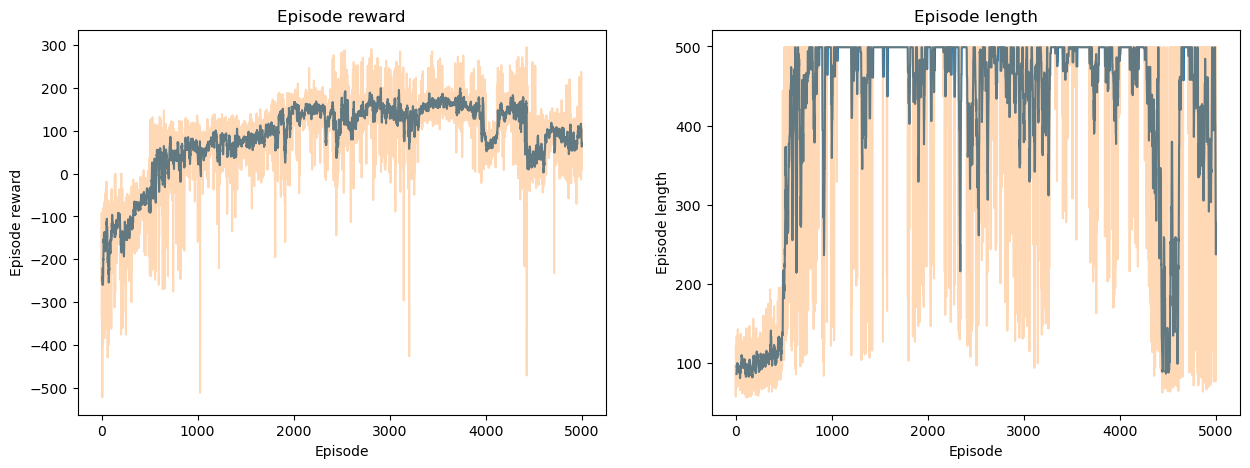

In [15]:
# Initialize the environment.
env_name = "LunarLander-v2"
env = gym.make(env_name)
# env_render = gym.make(env_name, render_mode="human")
env_render = None
action_size = env.action_space.n
state_size = env.observation_space.shape[0]
print("Action size:", action_size, "State size:", state_size)

# Hyperparameters
lr = 1e-2
gamma = 0.99
hidden_size = 16
episodes = 5000
max_length = 500
stats_every = 100 

# Initialize the policy agent
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
date = datetime.now().strftime("%Y%m%d-%H%M%S")
baseline = True
agent_name = "REINFORCE" + ("_BASELINE" if baseline else "")
agent_name = agent_name + "_" + date
agent = REINFORCEAgent(state_size, action_size, hidden_size, lr, gamma, baseline=baseline, device=device)

# Train the agent
train_agent(agent, agent_name, env, env_name, episodes, max_length, stats_every, env_render, device)

---
# Exercise 3.2: Solving Cartpole and Lunar Lander with `Deep Q-Learning` (harder)

On policy Deep Reinforcement Learning tends to be **very unstable**. Write an implementation (or adapt an existing one) of `Deep Q-Learning` to solve our two environments (Cartpole and Lunar Lander). To do this you will need to implement a **Replay Buffer** and use a second, slow-moving **target Q-Network** to stabilize learning.

In [21]:
# Replay Buffer
class ReplayBuffer():
    def __init__(self, size=16):
        self.buffer = deque([], maxlen=size)

    def push(self, data):
        self.buffer.append(data)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    
    def __len__(self):
        return len(self.buffer)

In [39]:
# Create a DQNetwork where the output is the Q value for each action
class FFNet(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size)
        )
        
    def forward(self, s):
        return self.net(s)

In [48]:
class DQNAgent():
    def __init__(self, state_size, action_size, hidden_size, lr, gamma, device='cuda'):
        self.action_size = action_size
        self.train_net = FFNet(state_size, action_size, hidden_size).to(device)
        self.target_net = FFNet(state_size, action_size, hidden_size).to(device)
        self.target_net.load_state_dict(self.train_net.state_dict())
        self.optimizer = optim.Adam(self.train_net.parameters(), lr=lr)
        self.lr = lr
        self.gamma = gamma

    def act(self, state, epsilon=0.):
        # Epsilon greedy policy
        if np.random.rand() <= epsilon:
            return np.random.choice(self.action_size)
        else:
            with torch.no_grad():
                state = torch.FloatTensor(state).to(device)
                q_values = self.train_net(state)
                return torch.argmax(q_values).item()
            
    def train(self, replay_buffer, batch_size, device='cuda'):
        # Sample a batch from the replay buffer
        batch = replay_buffer.sample(batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # Transform the lists to tensors and move to device
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device).view(-1, 1)
        rewards = torch.FloatTensor(rewards).to(device).view(-1, 1)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).to(device).view(-1, 1)

        # Compute the Q values from the train network
        train_q_values = self.train_net(states).gather(1, actions)

        # Compute the Q values from the target network
        with torch.no_grad():
            target_q_values = rewards + self.gamma * (1-dones) * torch.max(self.target_net(next_states), dim=1)[0].view(batch_size, -1)

        # Compute the loss between the train and target Q values
        # loss = F.mse_loss(train_q_values, target_q_values)
        # In this case we use the smooth L1 loss (similar to the Huber loss)
        loss = F.smooth_l1_loss(train_q_values, target_q_values)

        # Optimize the network
        self.optimizer.zero_grad()
        loss.backward()
        for p in self.train_net.parameters():
            p.grad.data.clamp_(-1, 1)
        self.optimizer.step()

        return loss.detach().cpu().numpy()
    
    def update_target(self, num_iter, update_freq):
        if not num_iter % update_freq:
            self.target_net.load_state_dict(self.train_net.state_dict())
            # print("Updated target network") 

In [50]:
# TRAIN AGENT
def train_agent(
        agent, 
        agent_name, 
        env, 
        env_name, 
        replay_buffer, 
        batch_size,
        episodes, 
        epsilon, 
        start_train,
        update_target_every,
        max_length=500, 
        stats_every=10, 
        env_render=None, 
        wb=False,
        device="cuda"
    ):
    # Initialize wandb
    if wb:
        wandb_init(agent, agent_name, env_name, episodes, device=device)

    # Track episode rewards in a list
    stats_reward_list = []
    tot_reward = 0
    steps = 0

    # Loop over the episodes
    for episode in tqdm(range(episodes), desc="Episodes", unit="episode", leave=True):
        # Generate the episode
        stats_loss = 0
        (state, info) = env.reset()

        # Run the episode  
        for length in range(max_length):
            steps += 1

            # Select an action
            action = agent.act(state, epsilon.get())
            # Do the action in the environment
            next_state, reward, term, trunc, _ = env.step(action)
            tot_reward += reward

            # If the episode is done, break
            if term or trunc or length == max_length-1: # or the total reward is too low (optional)
                # Store the transition in the replay buffer
                next_state = np.zeros(state.shape)
                reward = -1
                replay_buffer.push((state, action, reward, next_state, term))

                # Save the stats
                stats_reward_list.append((episode, tot_reward, length))

                # Wandb logging training stats
                if wb:
                    wandb.log({"train/total_reward": tot_reward, "train/episode_length": length, "train/loss": stats_loss}, step=episode)

                tot_reward = 0

                epsilon.update()

                if steps > start_train and not episode % stats_every:
                    # Evaluate the agent
                    total_reward = np.mean(stats_reward_list[-stats_every:], axis=0)[1]
                    total_length = np.mean(stats_reward_list[-stats_every:], axis=0)[2]
                    loss = stats_loss/stats_every
                    
                    print(f"Episode {episode}, Time steps: {length}, Total reward: {total_reward:.1f}, Episode length: {total_length:.1f}, Epsilon: {epsilon.get():.2f}, Loss: {stats_loss:.3f}")
                    if wb:
                        wandb.log({"eval/time_steps": length, "eval/total_reward": total_reward, "eval/episode_length": total_length, "eval/epsilon": epsilon.get(),"eval/loss": loss}, step=episode)

                    # Visualize the agent
                    if env_render is not None:
                        display_agent(agent, env_render)
                break
            else:
                # Store the transition in the replay buffer
                replay_buffer.push((state, action, reward, next_state, term))

            state = next_state

            if steps > start_train:
                # Train the agent
                stats_loss += agent.train(replay_buffer, batch_size)
                agent.update_target(steps, update_target_every)
    
    # Close the environment
    env.close()
    if env_render is not None:
        env_render.close()
    # Finish wandb
    if wb:
        wandb.finish()
    
    # Plot 
    plot_stats(stats_reward_list)

    return stats_reward_list


def display_agent(agent, env_render, max_length=500):
    (state, _) = env_render.reset()
    for _ in range(max_length):
        action = agent.act(state)
        (state, _, _, _, _) = env_render.step(action)


def plot_stats(stats_rewards_list):
    # plot stats
    def get_running_stat(stat, stat_len):
        cum_sum = np.cumsum(np.insert(stat, 0, 0)) 
        return (cum_sum[stat_len:] - cum_sum[:-stat_len]) / stat_len

    episode, r, l = np.array(stats_rewards_list).T
    cum_r = get_running_stat(r, 10)
    cum_l = get_running_stat(l, 10)

    # Plots
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].set_title("Episode reward")
    ax[0].plot(episode[-len(cum_r):], cum_r)
    ax[0].plot(episode, r, alpha=0.3)
    ax[0].set_xlabel("Episode")
    ax[0].set_ylabel("Episode reward")

    ax[1].set_title("Episode length")
    ax[1].plot(episode[-len(cum_l):], cum_l)
    ax[1].plot(episode, l, alpha=0.3)
    ax[1].set_xlabel("Episode")
    ax[1].set_ylabel("Episode length")
    

# Function to initialize wandb
def wandb_init(agent, algorithm, env, episodes, device="cuda", project="DLA Assigment 3"):
    # Initialize wandb
    wandb.init(
        project=project,
        name=algorithm,
        # Track hyperparameters and run metadata
        config={
            "algorithm": algorithm,
            "environment": env,
            "episodes": episodes,
            "learning_rate": agent.lr,
            "gamma": agent.gamma,
            "optimizer": "Adam",
            "device": device.type
        }
    )


class Epsilon():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay
        self.steps = (start - end) / decay
        self.epsilon = start

    def update(self):
        self.epsilon = max(self.end, self.epsilon - self.steps)

    def get(self):
        return self.epsilon

In [52]:
# Initialize the environment.
env_name = "CartPole-v1"
env = gym.make(env_name)
# env_render = gym.make(env_name, render_mode="human")
env_render = None
action_size = env.action_space.n
state_size = env.observation_space.shape[0]
# print("Action size:", action_size, "State size:", state_size)

# Hyperparameters
lr = 1e-3
gamma = 0.9
hidden_size = 16
episodes = 5000
max_length = 500
stats_every = 100
batch_size = 64

start_training = 100
update_target_every = 1000

epsilon = Epsilon(start=1.0, end=0.01, decay=episodes * .1)

# Initialize the Replay Buffer
buffer_size = 10000
buffer = ReplayBuffer(buffer_size)

# Initialize the DQN agent
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
date = datetime.now().strftime("%Y%m%d-%H%M%S")
agent_name = "DQN"
agent_name = agent_name + "_" + date
agent = DQNAgent(state_size, action_size, hidden_size, lr, gamma, device=device)

# Train the agent
train_agent(
    agent, 
    agent_name, 
    env, 
    env_name, 
    buffer, 
    batch_size, 
    episodes, 
    epsilon, 
    start_training, 
    update_target_every, 
    max_length, 
    stats_every, 
    env_render, 
    wb=False,
    device=device
    )

Episodes:   2%|▏         | 99/5000 [00:09<09:56,  8.22episode/s]

Episode 100, Time steps: 18, Total reward: 28.6, Episode length: 27.6, Epsilon: 0.80, Loss: 1.801


Episodes:   4%|▍         | 200/5000 [00:26<20:01,  4.00episode/s]

Episode 200, Time steps: 18, Total reward: 49.5, Episode length: 48.5, Epsilon: 0.60, Loss: 2.071


Episodes:   6%|▌         | 300/5000 [01:01<33:53,  2.31episode/s]

Episode 300, Time steps: 31, Total reward: 99.5, Episode length: 98.5, Epsilon: 0.40, Loss: 2.535


Episodes:   8%|▊         | 400/5000 [01:39<22:40,  3.38episode/s]

Episode 400, Time steps: 12, Total reward: 102.3, Episode length: 101.3, Epsilon: 0.21, Loss: 1.014


Episodes:  10%|▉         | 499/5000 [02:15<24:41,  3.04episode/s]

Episode 500, Time steps: 141, Total reward: 100.8, Episode length: 99.8, Epsilon: 0.01, Loss: 13.288


Episodes:  12%|█▏        | 600/5000 [02:52<26:55,  2.72episode/s]

Episode 600, Time steps: 57, Total reward: 98.6, Episode length: 97.6, Epsilon: 0.01, Loss: 5.263


Episodes:  14%|█▍        | 700/5000 [03:39<27:14,  2.63episode/s]  

Episode 700, Time steps: 104, Total reward: 125.8, Episode length: 124.8, Epsilon: 0.01, Loss: 7.542


Episodes:  16%|█▌        | 800/5000 [04:08<29:01,  2.41episode/s]

Episode 800, Time steps: 99, Total reward: 76.1, Episode length: 75.1, Epsilon: 0.01, Loss: 11.090


Episodes:  18%|█▊        | 900/5000 [04:45<24:28,  2.79episode/s]

Episode 900, Time steps: 111, Total reward: 95.8, Episode length: 94.8, Epsilon: 0.01, Loss: 9.586


Episodes:  20%|█▉        | 999/5000 [05:25<12:12,  5.47episode/s]

Episode 1000, Time steps: 90, Total reward: 105.4, Episode length: 104.4, Epsilon: 0.01, Loss: 8.174


Episodes:  22%|██▏       | 1100/5000 [05:45<21:25,  3.03episode/s]

Episode 1100, Time steps: 101, Total reward: 54.9, Episode length: 53.9, Epsilon: 0.01, Loss: 17.027


Episodes:  24%|██▍       | 1200/5000 [06:44<38:13,  1.66episode/s]  

Episode 1200, Time steps: 164, Total reward: 150.2, Episode length: 149.2, Epsilon: 0.01, Loss: 6.864


Episodes:  26%|██▌       | 1300/5000 [07:59<39:37,  1.56episode/s]  

Episode 1300, Time steps: 240, Total reward: 204.4, Episode length: 203.4, Epsilon: 0.01, Loss: 4.365


Episodes:  28%|██▊       | 1400/5000 [09:00<22:35,  2.65episode/s]  

Episode 1400, Time steps: 94, Total reward: 143.1, Episode length: 142.1, Epsilon: 0.01, Loss: 4.350


Episodes:  30%|███       | 1500/5000 [09:40<33:09,  1.76episode/s]

Episode 1500, Time steps: 128, Total reward: 100.0, Episode length: 99.0, Epsilon: 0.01, Loss: 2.351


Episodes:  32%|███▏      | 1600/5000 [10:45<38:37,  1.47episode/s]  

Episode 1600, Time steps: 116, Total reward: 167.3, Episode length: 166.3, Epsilon: 0.01, Loss: 0.857


Episodes:  34%|███▍      | 1700/5000 [11:32<27:56,  1.97episode/s]

Episode 1700, Time steps: 138, Total reward: 116.7, Episode length: 115.7, Epsilon: 0.01, Loss: 0.641


Episodes:  36%|███▌      | 1800/5000 [12:19<20:57,  2.54episode/s]

Episode 1800, Time steps: 124, Total reward: 112.8, Episode length: 111.8, Epsilon: 0.01, Loss: 0.939


Episodes:  38%|███▊      | 1900/5000 [13:15<33:10,  1.56episode/s]

Episode 1900, Time steps: 154, Total reward: 137.5, Episode length: 136.5, Epsilon: 0.01, Loss: 0.554


Episodes:  40%|████      | 2000/5000 [14:12<24:56,  2.00episode/s]

Episode 2000, Time steps: 139, Total reward: 138.8, Episode length: 137.8, Epsilon: 0.01, Loss: 0.199


Episodes:  42%|████▏     | 2100/5000 [15:10<33:47,  1.43episode/s]

Episode 2100, Time steps: 133, Total reward: 138.1, Episode length: 137.1, Epsilon: 0.01, Loss: 0.751


Episodes:  44%|████▍     | 2200/5000 [16:47<1:12:24,  1.55s/episode]

Episode 2200, Time steps: 415, Total reward: 237.4, Episode length: 236.4, Epsilon: 0.01, Loss: 4.598


Episodes:  44%|████▍     | 2219/5000 [17:02<18:01,  2.57episode/s]  

---
# Exercise 3.3: Solving the OpenAI CarRacing environment (hardest) 

Use `Deep Q-Learning` -- or even better, an off-the-shelf implementation of **Proximal Policy Optimization (PPO)** -- to train an agent to solve the [OpenAI CarRacing](https://github.com/andywu0913/OpenAI-GYM-CarRacing-DQN) environment. This will be the most *fun*, but also the most *difficult*. Some tips:

1. Make sure you use the `continuous=False` argument to the environment constructor. This ensures that the action space is **discrete** (we haven't seen how to work with continuous action spaces).
2. Your Q-Network will need to be a CNN. A simple one should do, with two convolutional + maxpool layers, folowed by a two dense layers. You will **definitely** want to use a GPU to train your agents.
3. The observation space of the environment is a single **color image** (a single frame of the game). Most implementations stack multiple frames (e.g. 3) after converting them to grayscale images as an observation.

In [ ]:
class Actor(nn.Module):
    def __init__(self, action_size, hidden_size=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.C

    def forward(self, s):
        return self.net(s)


class Critic(nn.Module):
    def __init__(self, args):
        super(Critic, self).__init__()


    def forward(self, s):
        s = self.activate_func(self.fc1(s))
        s = self.activate_func(self.fc2(s))
        v_s = self.fc3(s)
        return v_s
